In [1]:
# 載入套件 torch 相關套件
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from skimage import io
from model import U2NET
from torch.utils.data import Dataset, DataLoader

from modules.dataset import RescaleT
from modules.dataset import ToTensorLab
from modules.dataset import CustomDataset

In [2]:
def min_max_normalize(array):
    max_val = np.max(array)
    min_val = np.min(array)

    normalized = (array - min_val) / (max_val - min_val)

    return normalized

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = U2NET(in_ch=3, out_ch=1)
# 載入模型權重檔
model.load_state_dict(torch.load('model/weight/u2net_rice_panicle_image_extract.pth'))
# 將模型設定為評估模式
model.eval()
model = model.to(device)

cuda


(3840, 2160, 3)


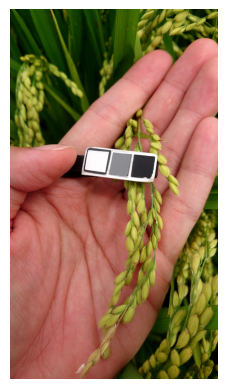

In [4]:
# 載入圖片
img_path = 'images/20230523101646.jpg'
img = Image.open(img_path)

rgb_img = np.float32(img)
print(rgb_img.shape)

origin_h, origin_w = rgb_img.shape[:2]

# 顯示圖片
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
image_paths = [img_path]
image_paths

['images/20230523101646.jpg']

In [6]:
test_salobj_dataset = CustomDataset(
    img_name_list=[img_path],
    lbl_name_list=[],
    transform=transforms.Compose([RescaleT(256), ToTensorLab(flag=0)])
)

test_dataloader = DataLoader(
    test_salobj_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

稻穗去背中...
稻穗影像去背處理中: images/20230523101646.jpg 1 / 1


c:\Users\Angle\Anaconda3\envs\py310-torch\lib\site-packages\torch\nn\functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(3840, 2160)


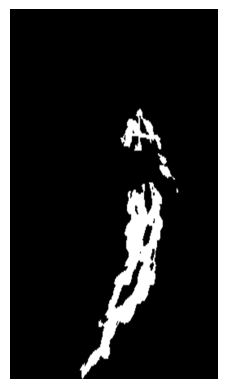

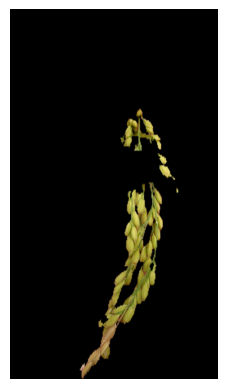

In [7]:
print('稻穗去背中...')
for i, data in enumerate(test_dataloader):
    print("稻穗影像去背處理中:", image_paths[i], f'{i + 1} / {len(test_dataloader)}')

    inputs_test = data['image']
    inputs_test = inputs_test.type(torch.FloatTensor)

    inputs_test = inputs_test.to(device)

    d1, d2, d3, d4, d5, d6, d7 = model(inputs_test)

    # print(d1.size())
    # print(d1.squeeze().size())
    
    # print(d2.size())
    # print(d2.squeeze().size())
    
    # print(d3.size())
    # print(d3.squeeze().size())
    
    # print(d4.size())
    # print(d4.squeeze().size())
    
    # print(d5.size())
    # print(d5.squeeze().size())
    
    # print(d6.size())
    # print(d6.squeeze().size())
    
    # print(d7.size())
    # print(d7.squeeze().size())

    # Normalization
    pred = d1.squeeze().cpu().detach().numpy()
    pred = min_max_normalize(pred)

    # Save prediction
    binary_result = (pred > 0.5).astype(np.uint8)  # 轉換為 0 和 1
    binary_result = binary_result * 255  # 轉換為 0 和 255
    mask = cv2.resize(binary_result, (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)
    print(mask.shape)

    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()
    
    output_path = f'results/prediction_{i+1}.png'
    cv2.imwrite(output_path, mask)


    # Save segmentation
    origin_image = cv2.imread(image_paths[i])
    origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
    segmentation = (origin_image * (mask[..., None] / 255)).astype(np.uint8)

    plt.imshow(segmentation)
    plt.axis('off')
    plt.show()

    output_path = f'results/segmentation_{i+1}.png'
    segmentation_bgr = cv2.cvtColor(segmentation, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, segmentation_bgr)